# When is Multicollinearity an Issue?

> A causal perspective

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp multicollinearity

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import warnings
from tueplots import bundles
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb
from common_regression_issues.utils.plotting import rgb_to_hex
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [ ]:
#| hide
import xarray as xr
import pandas as pd
import numpy as np
from common_regression_issues.synthetic_data.multicollinearity_datagen import sample_random_data, hill

In [ ]:
#| hide
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#| hide
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

## The DAG

```{dot}
//| label: fig-causal-graph
//| fig-cap: The causal graph reflects our assumptions about the data-generating process in this example. This model may need refinement, so it’s essential to review it with experts and stakeholders to enhance its structure and incorporate additional factors that could influence the variables of interest.
//| fig-cap-location: bottom

digraph "Paid Media on Sales" {
  Seasonality, Demand, Auction [color="#AFB3B7" style=dashed];
  Seasonality -> "OLV Impression";
  "Video Platform Sentiment" -> "OLV Impression";
  "OLV Impression" -> Demand;
  Seasonality -> Demand;
  Seasonality -> "Social Impression";
  "Social Impression" -> Demand;
  "Search Query" -> Auction;
  "Search Query" -> "Paid Search Impression";
  Auction -> "Paid Search Impression";
  Demand -> "Search Query";
  Seasonality -> "Search Query";
  "Paid Search Impression" -> "Paid Search Click";
  Demand -> "Paid Search Click";
  "Search Query" -> "Paid Search Click";
  "Search Query" -> "Organic Search";
  "Organic Search" -> Sales;
  Demand -> Sales;
  "Paid Search Click" -> Sales;
  Price -> Demand;
  Price -> Sales;
}
```

::: {.callout-note collapse="true" #note-dag-notation}
## How to read a DAG
A Directed Acyclic Graph (DAG) serves as a model of causality, where directional relationships between nodes indicate that causes flow from one node to another along the arrows, forming a distinct pathway of influence. Each arrow represents a causal link, signaling how changes in one node could potentially impact another. In a DAG, the relationships between nodes (depicted by an arrow) are not restricted to being linear; they can incorporate complex, non-linear interactions.

Edges will be color-coded to emphasize whether they represent causal paths (green <button disabled style="background-color: #326E1E; height: 13px; width: 11px;"></button>), biasing paths (red <button disabled style="background-color: #8D2D39; height: 13px; width: 11px;"></button>), or non-causal paths (black <button disabled style="background-color: #000000; height: 13px; width: 11px;"></button>). Refer to @fig-causal-graph-paid-search and @fig-causal-graph-paid-search-adjusted.

Nodes indicating exposures (factors for which we want to understand the effect) will have a green background (<button disabled style="background-color: #82B9A0; height: 13px; width: 11px;"></button>). The outcome variable of interest will have a blue background (<button disabled style="background-color: #0069AA; height: 13px; width: 11px;"></button>), while variables adjusted for will have a light gray background (<button disabled style="background-color: #AFB3B7; height: 13px; width: 11px;"></button>). Nodes with a dashed outline represent elements that are challenging or impossible to observe directly, while nodes with a solid outline and no fill represent variables for which data is available or can be acquired.
:::

### How Effective is Paid Search at Driving Sales? {#sec-paid-search}

To accurately measure the impact of Paid Search on Sales, we must carefully consider the causal pathways influencing this relationship. The causal model presented in @fig-causal-graph reveals several open biasing paths from both **paid search impressions** and **paid search clicks** to **sales**. These open paths introduce potential sources of bias that can distort our understanding of Paid Search’s effectiveness.

Additionally, the DAG highlights a complex correlation structure within the data, which suggests that variables may be highly interrelated. This correlation can lead to high Variance Inflation Factors (VIFs) in a regression model. 

Elevated VIFs inflate standard errors and reduce the precision of our estimates, but excluding the wrong variables could result in biased estimates. Balancing these considerations—minimizing multicollinearity without overlooking key variables—is essential for creating a model that yields accurate and precise estimates of paid search’s impact on sales.

#### Solution {#sec-paid-search-solution}

To get an unbiased estimate of the effect of **paid search impressions** on **sale**, given the bias introduced by **demand** (an unobserved variable), focusing on **search query** as an adjustment variable is a sound approach. Here’s a breakdown of the reasoning and approach based on the DAG structure:

1.	Direct Path and Biasing Path:
	- **Paid search clicks** have a direct impact on sales, but due to **demand** (which is unobserved and thus unadjustable in this analysis), there’s a risk of confounding.
	- Since **demand** also influences **search query**, which in turn influences both **paid search impressions** and **paid search clicks**, **search query** becomes a potential control variable to block the non-causal path through **demand**. See @fig-causal-graph-paid-search
2.	Adjustment for Search Query:
	- By adjusting for search query, we aim to block the path from demand that leads through **search query** to both **paid search impressions** and **paid search clicks**. This adjustment helps remove the confounding influence of **demand** on **sales** via **search query**, allowing for a more accurate estimate of **paid search impressions’** effect on **sales**. See @fig-causal-graph-paid-search-adjusted
3.	Outcome:
	- Adjusting for **search query** should allow for a clearer view of the total effect of **paid search impressions** on **sales** by blocking the biasing path from **demand**, leading to a more reliable analysis.

In summary, adjusting for **search query** effectively helps control for the unobserved demand factor, allowing us to examine the impact of **paid search impressions** on **sales** with minimized bias. We can also increase the precision of this estimate by controlling for **price**.

::: {.panel-tabset group=Models}

## Un-Adjusted Model
```{dot}
//| label: fig-causal-graph-paid-search
//| fig-cap: We aim to understand the effect of **Paid Search Impressions** on **Sales**. Without any adjustments, all biasing paths remain open. To accurately estimate this effect, we need to adjust for variables that close these biasing paths and include additional variables to reduce variance in our estimate.
//| fig-cap-location: bottom

digraph "Paid Media on Sales" {
  //Exposure
  "Paid Search Impression" [color="#7DA54B" fillcolor="#82B9A0" style=filled];
  //Outcome
  Sales [fillcolor="#0069AA" fontcolor=white style=filled];
  //Adjusted
  //Price [fillcolor="#AFB3B7" style=filled]
  //Un-Observed
  "OLV Impression", "Social Impression", "Video Platform Sentiment" [color="#AFB3B7"]; 
  "Search Query", "Paid Search Click", Price, "Organic Search" [color="#AFB3B7"];
  //Un-Observable
  Seasonality, Demand, Auction [color="#AFB3B7" style=dashed];
  "Video Platform Sentiment" -> "OLV Impression";
  Seasonality -> "OLV Impression" [color="#8D2D39"];
  "OLV Impression" -> Demand [color="#8D2D39"];
  Seasonality -> Demand [color="#8D2D39"];
  Seasonality -> "Social Impression" [color="#8D2D39"];
  "Social Impression" -> Demand [color="#8D2D39"];
  "Search Query" -> Auction [color="#8D2D39"];
  "Search Query" -> "Paid Search Impression" [color="#8D2D39"];
  Auction -> "Paid Search Impression" [color="#8D2D39"];
  Demand -> "Search Query" [color="#8D2D39"];
  Seasonality -> "Search Query" [color="#8D2D39"];
  "Paid Search Impression" -> "Paid Search Click" [color="#8D2D39" style=bold];
  Demand -> "Paid Search Click" [color="#8D2D39"];
  "Search Query" -> "Paid Search Click" [color="#8D2D39"];
  "Search Query" -> "Organic Search" [color="#8D2D39"];
  "Organic Search" -> Sales [color="#8D2D39"];
  Demand -> Sales [color="#8D2D39"];
  "Paid Search Click" -> Sales [color="#8D2D39" style=bold];
  Price -> Demand [color="#8D2D39"];
  Price -> Sales [color="#8D2D39"];
}
```

## Adjusted Model
```{dot}
//| label: fig-causal-graph-paid-search-adjusted
//| fig-cap: Adjusting for **Search Query** closes all biasing paths. Additionally, **Price** is adjusted, not to close biasing paths, but to reduce the variance in estimating the effect of **Paid Search Impressions** on **Sales**.
//| fig-cap-location: bottom

digraph "Paid Media on Sales" {
  //Exposure
  "Paid Search Impression" [color="#7DA54B" fillcolor="#82B9A0" style=filled];
  //Outcome
  Sales [fillcolor="#0069AA" fontcolor=white style=filled];
  //Adjusted
  Price, "Search Query" [fillcolor="#AFB3B7" style=filled]
  //Un-Observed
  "OLV Impression", "Social Impression", "Video Platform Sentiment"[color="#AFB3B7"]; 
  "Paid Search Click", "Organic Search" [color="#AFB3B7"];
  //Un-Observable
  Seasonality, Demand, Auction [color="#AFB3B7" style=dashed];
  Seasonality -> "OLV Impression";
  "Video Platform Sentiment" -> "OLV Impression";
  "OLV Impression" -> Demand;
  Seasonality -> Demand;
  Seasonality -> "Social Impression";
  "Social Impression" -> Demand;
  "Search Query" -> Auction;
  "Search Query" -> "Paid Search Impression";
  Auction -> "Paid Search Impression";
  Demand -> "Search Query";
  Seasonality -> "Search Query";
  "Paid Search Impression" -> "Paid Search Click" [color="#326E1E" style=bold];
  Demand -> "Paid Search Click";
  "Search Query" -> "Paid Search Click";
  "Search Query" -> "Organic Search";
  "Organic Search" -> Sales;
  Demand -> Sales;
  "Paid Search Click" -> Sales [color="#326E1E" style=bold];
  Price -> Demand;
  Price -> Sales;
  Seasonality -> Sales;
}
```
:::

In [ ]:
#| hide
dataset = sample_random_data(156, random_seed=2, include_hidden_confounds=True)
dataset.head()

<xarray.Dataset> Size: 520B
Dimensions:                  (Period: 5)
Coordinates:
  * Period                   (Period) datetime64[ns] 40B 2021-01-04 ... 2021-...
Data variables:
    price                    (Period) float64 40B 3.856 3.767 3.767 4.3 4.3
    season                   (Period) float64 40B -0.9613 -0.9732 ... -1.0
    olv_sentiment            (Period) int64 40B 0 0 0 0 0
    social_impressions       (Period) float64 40B 4.516e+03 ... 2.289e+03
    olv_impressions          (Period) float64 40B 1.69e+04 ... 1.227e+04
    demand                   (Period) float64 40B 28.92 29.4 31.64 27.92 26.14
    search_query             (Period) float64 40B 2.182e+06 ... 2.366e+06
    auction                  (Period) float64 40B 0.07852 0.08937 ... 0.0854
    paid_search_impressions  (Period) float64 40B 1.713e+05 ... 2.021e+05
    paid_search_clicks       (Period) float64 40B 669.2 938.3 ... 645.8 636.1
    organic_search           (Period) float64 40B 2.054e+06 ... 2.055e+06
    sales                    (Period) float64 40B 6.47e+03 ... 6.29e+03
Attributes:
    olv_params:     {'K': 0.7960875579897572, 'n': 1.0072716356157956}
    social_params:  {'K': 0.9767776434467591, 'n': 2.7744792328982424}
    olv_beta:       0.21671224557085256
    social_beta:    0.06881513644667057

::: {.panel-tabset}

## Correlation Matrix

In [ ]:
#| echo: false
#| label: fig-corr-matrix
#| fig-cap: Correlation matrix
df = dataset.to_dataframe()
columns = df.columns
varnames = ['paid_search_impressions', 'search_query', 'price']
np.log(df[varnames + ['sales']]).corr().style.background_gradient(cmap='RdYlGn', vmin=-1, vmax=1).format(precision=2)

,paid_search_impressions,search_query,price,sales
paid_search_impressions,1.00,0.93,-0.34,0.90
search_query,0.93,1.00,-0.33,0.91
price,-0.34,-0.33,1.00,-0.19
sales,0.90,0.91,-0.19,1.00


## VIFs

In [ ]:
#| echo: false
#| label: tbl-vifs
#| tbl-cap: VIF for the regression model
print(f"{'':26} VIF")
for i, name in enumerate(varnames):
    print(f"{name.ljust(25, ' ')}: {np.round(variance_inflation_factor(np.log(df[varnames]), i),2)}")

                           VIF
paid_search_impressions  : 1667.63
search_query             : 1952.48
price                    : 72.44


:::

With our adjustment set established, let’s examine the correlation structure among the key variables (**paid search impressions**, **search query**, **price**, and **sales**). As shown in @fig-corr-matrix, **search query** and **paid search impressions** exhibit a high correlation. Additionally, the VIF values presented in @tbl-vifs reveal some extreme figures.

Rather than being immediately concerned about the high VIFs (even those exceeding 1000), let’s proceed by running the regression to assess the actual impact.

In @tbl-adjusted, the standard errors for the coefficients are reasonably sized. Since this is synthetic data, we can compare the estimated coefficient for **paid search impressions** to the expected value of 0.4, which indeed falls within the confidence interval for this coefficient.

In @tbl-unadjusted, where **search query** is excluded from the model, we observe a reduction in standard errors. However, this reduction comes at the expense of introducing bias into the estimate of **paid search impressions'** effect on **sales**. In fact it produces an estimate that is much larger than the true value.

Given that the correctly adjusted model provides an estimate with reasonable precision, it should be preferred, even in light of the high VIFs.

In [ ]:
#| hide
adjusted_model = sm.OLS(np.log(df['sales']), sm.add_constant(np.log(df[['paid_search_impressions', "search_query", "price"]]))).fit()

In [ ]:
#| hide
unadjusted_model = sm.OLS(np.log(df['sales']), sm.add_constant(np.log(df[['paid_search_impressions', "price"]]))).fit()

:::{.panel-tabset group=Models}

## Un-Adjusted Model


In [ ]:
#| echo: false
#| label: tbl-unadjusted
#| tbl-cap: The unadjusted regression of the form $$log(Sales) \sim \beta_{psi} log(Paid Search Impressions) + \beta_p log(Price)$$
unadjusted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     379.1
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           5.21e-60
Time:                        22:29:24   Log-Likelihood:                -27.949
No. Observations:                 156   AIC:                             61.90
Df Residuals:                     153   BIC:                             71.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.0391      0.532     -3.835      0.000      -3.090      -0.989
paid_search_impressions     0.8323      0.031     26.950      0.000       0.771       0.893
price                       0.6034      0.160      3.779      0.000       0.288       0.919
==============================================================================
Omnibus:                        1.250   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.535   Jarque-Bera (JB):                0.862
Skew:                           0.042   Prob(JB):                        0.650
Kurtosis:                       3.354   Cond. No.                         299.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Adjusted Model

In [ ]:
#| echo: false
#| label: tbl-adjusted
#| tbl-cap: The correctly adjusted regression model of the following form $$log(Sales) \sim \beta_{SQ} log(Search Query) + \beta_{psi} log(Paid Search Impressions) + \beta_p log(Price)$$
adjusted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     331.6
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.82e-66
Time:                        22:29:24   Log-Likelihood:                -9.4959
No. Observations:                 156   AIC:                             26.99
Df Residuals:                     152   BIC:                             39.19
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -4.1601      0.579     -7.182      0.000      -5.305      -3.016
paid_search_impressions     0.4287      0.069      6.205      0.000       0.292       0.565
search_query                0.4739      0.074      6.369      0.000       0.327       0.621
price                       0.6448      0.142      4.526      0.000       0.363       0.926
==============================================================================
Omnibus:                        0.507   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.776   Jarque-Bera (JB):                0.214
Skew:                          -0.035   Prob(JB):                        0.899
Kurtosis:                       3.167   Cond. No.                         559.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

:::

### When High VIFs are an issue

While high VIFs are not inherently problematic, they serve as a useful diagnostic tool for identifying potential issues in regression results. Let’s explore this further with a slightly more complex example.

### How effective is OLV at driving sales?

From the causal model, we can see that **seasonality** is part of the necessary adjustment set to accurately estimate the effect of **OLV impressions** on **sales**. Although seasonality is unobserved, we can reasonably approximate it using a periodic function (e.g., sine or cosine terms) to capture seasonal fluctuations over time. Let's consider the following model were we adjust for **seasonality** (using fourier terms), **price**, **olv impressions**, and **Video Platform Sentiment** (`olv_sentiment` in the models). Note that **Video Platform Sentiment** is not a confounder, typically we would not adjust for it, but we include it here to illustrate the point that adjusting for variables that are not confounders can needlessly increase VIFs.

In [ ]:
#| hide
dataset

<xarray.Dataset> Size: 16kB
Dimensions:                  (Period: 156)
Coordinates:
  * Period                   (Period) datetime64[ns] 1kB 2021-01-04 ... 2023-...
Data variables:
    price                    (Period) float64 1kB 3.856 3.767 ... 4.556 4.556
    season                   (Period) float64 1kB -0.9613 -0.9732 ... -0.9523
    olv_sentiment            (Period) int64 1kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    social_impressions       (Period) float64 1kB 4.516e+03 ... 3.674e+03
    olv_impressions          (Period) float64 1kB 1.69e+04 ... 1.351e+04
    demand                   (Period) float64 1kB 28.92 29.4 ... 22.41 24.78
    search_query             (Period) float64 1kB 2.182e+06 ... 1.094e+06
    auction                  (Period) float64 1kB 0.07852 0.08937 ... 0.08624
    paid_search_impressions  (Period) float64 1kB 1.713e+05 ... 9.438e+04
    paid_search_clicks       (Period) float64 1kB 669.2 938.3 ... 497.7 459.5
    organic_search           (Period) float64 1kB 2.054e+06 ... 9.556e+05
    sales                    (Period) float64 1kB 6.47e+03 ... 5.232e+03
Attributes:
    olv_params:     {'K': 0.7960875579897572, 'n': 1.0072716356157956}
    social_params:  {'K': 0.9767776434467591, 'n': 2.7744792328982424}
    olv_beta:       0.21671224557085256
    social_beta:    0.06881513644667057

:::{.panel-tabset group=OLV}

## Over Adjusted Model

```{dot}
//| label: fig-olv-on-sales-adjusted
//| fig-cap: The causal graph for the relationship between **OLV Impressions** and **Sales**. Adjusting for **Seasonality** and **Price** closes all biasing paths, allowing for an unbiased estimate of the effect of **OLV Impressions** on **Sales**. Including **Video Platform Sentement** does nothing to reduce bias and only adds variance of our estimate.
//| fig-cap-location: bottom

digraph "Paid Media on Sales" {
  //Exposure
  "OLV Impression" [color="#7DA54B" fillcolor="#82B9A0" style=filled];
  //Outcome
  Sales [fillcolor="#0069AA" fontcolor=white style=filled];
  //Adjusted
  Price, "Video Platform Sentiment"  [fillcolor="#AFB3B7" style=filled];
  Seasonality [fillcolor="#AFB3B7" style="filled,dashed"];
  //Un-Observed
  "Search Query", "Paid Search Impression", "Social Impression"[color="#AFB3B7"]; 
  "Paid Search Click", "Organic Search" [color="#AFB3B7"];
  //Un-Observable
  Demand, Auction [color="#AFB3B7" style=dashed];
  Seasonality -> "OLV Impression";
  "Video Platform Sentiment" -> "OLV Impression";
  "OLV Impression" -> Demand [color="#326E1E" style=bold];
  Seasonality -> Demand;
  Seasonality -> "Social Impression";
  "Social Impression" -> Demand;
  "Search Query" -> Auction [color="#326E1E" style=bold];
  "Search Query" -> "Paid Search Impression" [color="#326E1E" style=bold];
  Auction -> "Paid Search Impression" [color="#326E1E" style=bold];
  Demand -> "Search Query" [color="#326E1E" style=bold];
  Seasonality -> "Search Query";
  "Paid Search Impression" -> "Paid Search Click" [color="#326E1E" style=bold];
  Demand -> "Paid Search Click" [color="#326E1E" style=bold];
  "Search Query" -> "Paid Search Click" [color="#326E1E" style=bold];
  "Search Query" -> "Organic Search" [color="#326E1E" style=bold];
  "Organic Search" -> Sales [color="#326E1E" style=bold];
  Demand -> Sales [color="#326E1E" style=bold];
  "Paid Search Click" -> Sales [color="#326E1E" style=bold];
  Price -> Demand;
  Price -> Sales;
  Seasonality -> Sales;
}
```

## Correctly Adjusted Model

```{dot}
//| label: fig-olv-on-sales-adjusted
//| fig-cap: Adjusting for **Seasonality** and **Price** closes all biasing paths, allowing for an unbiased estimate of the effect of **OLV Impressions** on **Sales**.
//| fig-cap-location: bottom

digraph "Paid Media on Sales" {
  //Exposure
  "OLV Impression" [color="#7DA54B" fillcolor="#82B9A0" style=filled];
  //Outcome
  Sales [fillcolor="#0069AA" fontcolor=white style=filled];
  //Adjusted
  Price [fillcolor="#AFB3B7" style=filled];
  Seasonality [fillcolor="#AFB3B7" style="filled,dashed"];
  //Un-Observed
  "Search Query", "Paid Search Impression", "Social Impression", "Video Platform Sentiment"[color="#AFB3B7"]; 
  "Paid Search Click", "Organic Search" [color="#AFB3B7"];
  //Un-Observable
  Demand, Auction [color="#AFB3B7" style=dashed];
  Seasonality -> "OLV Impression";
  "Video Platform Sentiment" -> "OLV Impression";
  "OLV Impression" -> Demand [color="#326E1E" style=bold];
  Seasonality -> Demand;
  Seasonality -> "Social Impression";
  "Social Impression" -> Demand;
  "Search Query" -> Auction [color="#326E1E" style=bold];
  "Search Query" -> "Paid Search Impression" [color="#326E1E" style=bold];
  Auction -> "Paid Search Impression" [color="#326E1E" style=bold];
  Demand -> "Search Query" [color="#326E1E" style=bold];
  Seasonality -> "Search Query";
  "Paid Search Impression" -> "Paid Search Click" [color="#326E1E" style=bold];
  Demand -> "Paid Search Click" [color="#326E1E" style=bold];
  "Search Query" -> "Paid Search Click" [color="#326E1E" style=bold];
  "Search Query" -> "Organic Search" [color="#326E1E" style=bold];
  "Organic Search" -> Sales [color="#326E1E" style=bold];
  Demand -> Sales [color="#326E1E" style=bold];
  "Paid Search Click" -> Sales [color="#326E1E" style=bold];
  Price -> Demand;
  Price -> Sales;
  Seasonality -> Sales;
}
```

:::

:::{.callout-note collapse="true" #note-fourier-components}
## Fourier Seasonality

To capture the seasonal fluctuations in the data, we can use Fourier terms to approximate the unobserved **seasonality** variable. These terms are periodic functions that can model the cyclical patterns in the data, allowing us to adjust for the influence of **seasonality** on **sales** and **OLV impressions**. By including these terms in the regression model, we can effectively control for the confounding effect of **seasonality** and obtain an unbiased estimate of the effect of **OLV impressions** on **sales**.

In [ ]:
#| export
def generate_fourier_components(
  N_samples: int, # Number of samples
  N_components: int = 3, # Half the number of Fourier components
  period: int = 52 # Yearly period of weekly data
) -> pd.DataFrame: # Dataframe with fourier components
    "Generate Fourier components for a given number of samples and components."
    t = np.linspace(0, N_samples, N_samples)
    fourier_components = pd.DataFrame()
    for i in range(N_components):
        fourier_components[f'fourier_sin_{i}'] = np.sin(2 * np.pi * (i + 1) * t / period)
    for i in range(N_components):
        fourier_components[f'fourier_cos_{i}'] = np.cos(2 * np.pi * (i + 1) * t / period)
    return fourier_components
  

In [ ]:
fourier_components = generate_fourier_components(dataset.Period.shape[0], 3, 52)
fourier_components.head()

,fourier_sin_0,fourier_sin_1,fourier_sin_2,fourier_cos_0,fourier_cos_1,fourier_cos_2
0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
1,0.121311,0.240829,0.356791,0.992615,0.970568,0.934184
2,0.240829,0.467482,0.666616,0.970568,0.884003,0.745401
3,0.356791,0.666616,0.888695,0.934184,0.745401,0.458499
4,0.467482,0.826511,0.993793,0.884003,0.562921,0.111245


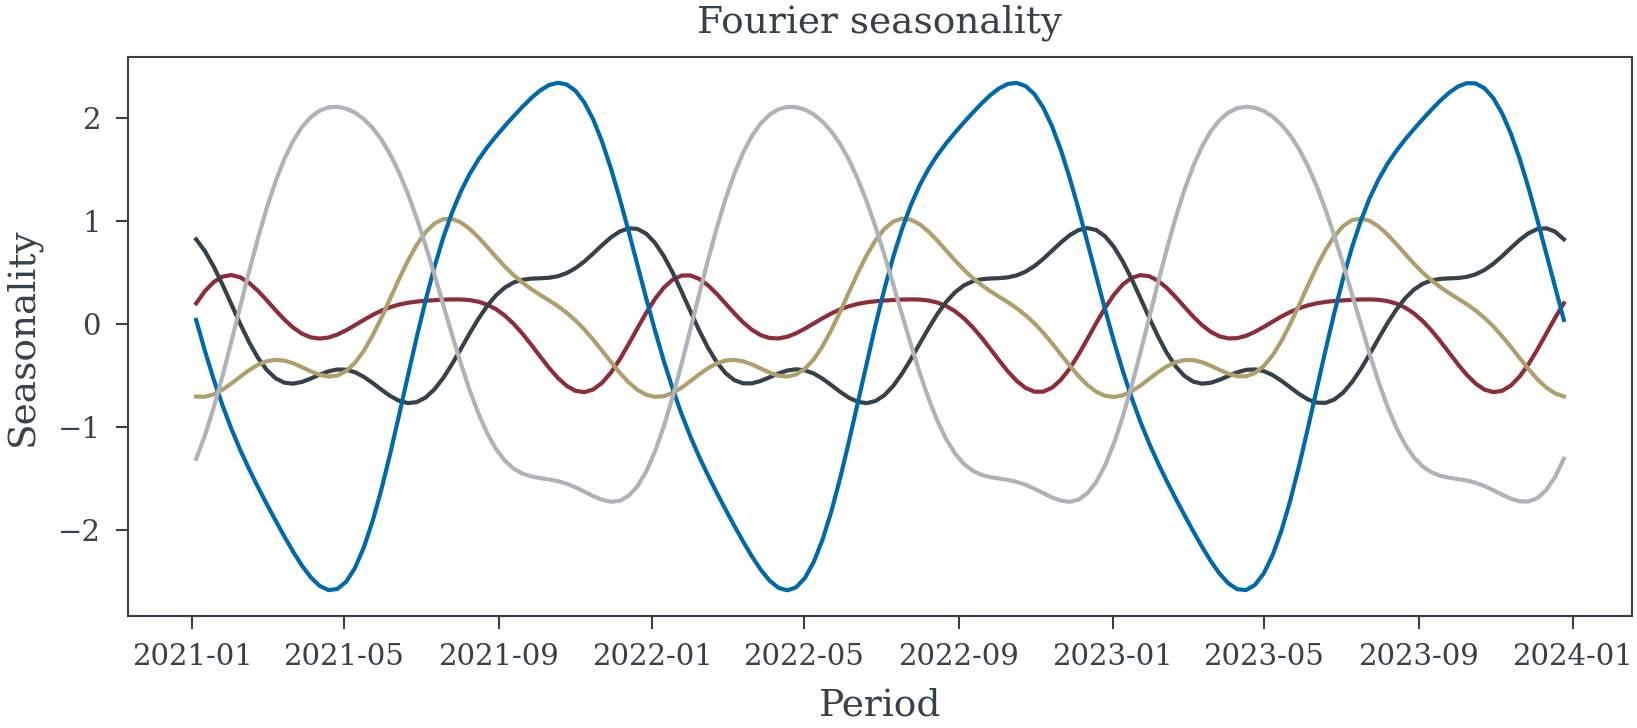

In [ ]:
#| echo: false
#| label: fig-fourier-season-samples
#| fig-cap: Fourier seasonality
rng = np.random.default_rng(2)
fourier_betas = rng.normal(0, 1, size=(6, 5))
seasonality = (fourier_components @ (fourier_betas 
               / np.array(
                 [(i + 1)**2 for i in range(3)] 
                 + [(i + 1)**2 for i in range(3)]
                )[:, None]))
plt.plot(dataset.Period, seasonality)
plt.xlabel('Period')
plt.ylabel('Seasonality')
plt.title('Fourier seasonality');


:::

In [ ]:
#| hide
dataset.head()

<xarray.Dataset> Size: 520B
Dimensions:                  (Period: 5)
Coordinates:
  * Period                   (Period) datetime64[ns] 40B 2021-01-04 ... 2021-...
Data variables:
    price                    (Period) float64 40B 3.856 3.767 3.767 4.3 4.3
    season                   (Period) float64 40B -0.9613 -0.9732 ... -1.0
    olv_sentiment            (Period) int64 40B 0 0 0 0 0
    social_impressions       (Period) float64 40B 4.516e+03 ... 2.289e+03
    olv_impressions          (Period) float64 40B 1.69e+04 ... 1.227e+04
    demand                   (Period) float64 40B 28.92 29.4 31.64 27.92 26.14
    search_query             (Period) float64 40B 2.182e+06 ... 2.366e+06
    auction                  (Period) float64 40B 0.07852 0.08937 ... 0.0854
    paid_search_impressions  (Period) float64 40B 1.713e+05 ... 2.021e+05
    paid_search_clicks       (Period) float64 40B 669.2 938.3 ... 645.8 636.1
    organic_search           (Period) float64 40B 2.054e+06 ... 2.055e+06
    sales                    (Period) float64 40B 6.47e+03 ... 6.29e+03
Attributes:
    olv_params:     {'K': 0.7960875579897572, 'n': 1.0072716356157956}
    social_params:  {'K': 0.9767776434467591, 'n': 2.7744792328982424}
    olv_beta:       0.21671224557085256
    social_beta:    0.06881513644667057

:::{.panel-tabset group=OLV}

## Over Adjusted Model

In [ ]:
#| echo: false
#| label: tbl-vifs-fourier
#| tbl-cap: VIF for the regression model with Fourier components with the addition of OLV sentiment
df = pd.concat([dataset.to_dataframe().reset_index(), fourier_components], axis=1)
varnames = ['hill_olv', 'log_price', 'olv_sentiment'] + fourier_components.columns.tolist()
df['log_price'] = np.log(df['price'])
df['hill_olv'] = hill(df['olv_impressions']/(dataset.olv_impressions.where(dataset.olv_impressions>0).median().values), **dataset.attrs['olv_params'])
print(f"{'':14} VIF")
for i, name in enumerate(varnames):
    print(f"{name.ljust(13, ' ')}: {np.round(variance_inflation_factor((df[varnames]), i),2)}")

               VIF
hill_olv     : 70.91
log_price    : 57.59
olv_sentiment: 4.43
fourier_sin_0: 1.01
fourier_sin_1: 1.01
fourier_sin_2: 1.0
fourier_cos_0: 1.42
fourier_cos_1: 1.01
fourier_cos_2: 1.01


## Correctly Adjusted Model

In [ ]:
#| echo: false
#| label: tbl-vifs-fourier-correct
#| tbl-cap: VIF for the regression model with Fourier components without the addition of OLV sentiment
df = pd.concat([dataset.to_dataframe().reset_index(), fourier_components], axis=1)
varnames = ['hill_olv', 'log_price'] + fourier_components.columns.tolist()
df['log_price'] = np.log(df['price'])
df['hill_olv'] = hill(df['olv_impressions']/(dataset.olv_impressions.where(dataset.olv_impressions>0).median().values), **dataset.attrs['olv_params'])
print(f"{'':14} VIF")
for i, name in enumerate(varnames):
    print(f"{name.ljust(13, ' ')}: {np.round(variance_inflation_factor((df[varnames]), i),2)}")

               VIF
hill_olv     : 18.98
log_price    : 18.84
fourier_sin_0: 1.01
fourier_sin_1: 1.0
fourier_sin_2: 1.0
fourier_cos_0: 1.14
fourier_cos_1: 1.0
fourier_cos_2: 1.0


:::

:::{.callout-tip collapse="true"}
## Vectors Spaces and Basis Vectors
Fourier components provide an orthogonal basis for the space of periodic functions with a given period  $L$ . This orthogonality helps to address multicollinearity, which is why the VIFs in @tbl-vifs-fourier-correct and @tbl-vifs-fourier are all near 1 for the fourier components!
:::

:::{.panel-tabset group=OLV}

## Over Adjusted Model

In [ ]:
#| echo: false
#| label: tbl-vifs-fourier-olv
#| tbl-cap: The over adjusted regression model with Fourier components with the addition of OLV sentiment
ols_model = sm.OLS(np.log(df['sales']), sm.add_constant(df[varnames])).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     128.3
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           9.51e-65
Time:                        22:41:07   Log-Likelihood:                 3.4816
No. Observations:                 156   AIC:                             13.04
Df Residuals:                     146   BIC:                             43.54
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.7020      0.324     32.982      0.000      10.061      11.343
hill_olv          0.7217      0.433      1.665      0.098      -0.135       1.578
log_price        -1.0720      0.127     -8.433      0.000      -1.323      -0.821
olv_sentiment     0.0183      0.161      0.114      0.909      -0.299       0.336
fourier_sin_0     0.0449      0.028      1.591      0.114      -0.011       0.101
fourier_sin_1     0.0214      0.028      0.768      0.444      -0.034       0.077
fourier_sin_2     0.0166      0.028      0.596      0.552      -0.038       0.072
fourier_cos_0    -0.8321      0.041    -20.141      0.000      -0.914      -0.750
fourier_cos_1     0.1959      0.028      6.963      0.000       0.140       0.251
fourier_cos_2     0.0084      0.028      0.303      0.763      -0.046       0.063
==============================================================================
Omnibus:                        0.997   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                0.912
Skew:                          -0.186   Prob(JB):                        0.634
Kurtosis:                       2.964   Cond. No.                         53.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Correctly Adjusted Model

In [ ]:
#| echo: false
#| label: tbl-vifs-fourier-olv-no-sentiment
#| tbl-cap: The correctly adjusted regression model with Fourier components and no OLV sentiment
correct_varnames = ['hill_olv', 'log_price'] + fourier_components.columns.tolist()
ols_model = sm.OLS(np.log(df['sales']), sm.add_constant(df[correct_varnames])).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     145.4
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           7.68e-66
Time:                        22:39:52   Log-Likelihood:                 3.4747
No. Observations:                 156   AIC:                             11.05
Df Residuals:                     147   BIC:                             38.50
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.6756      0.226     47.201      0.000      10.229      11.123
hill_olv          0.7678      0.157      4.898      0.000       0.458       1.078
log_price        -1.0712      0.126     -8.468      0.000      -1.321      -0.821
fourier_sin_0     0.0444      0.028      1.597      0.112      -0.011       0.099
fourier_sin_1     0.0215      0.028      0.773      0.441      -0.033       0.076
fourier_sin_2     0.0167      0.028      0.603      0.548      -0.038       0.071
fourier_cos_0    -0.8289      0.030    -27.407      0.000      -0.889      -0.769
fourier_cos_1     0.1953      0.028      7.081      0.000       0.141       0.250
fourier_cos_2     0.0086      0.028      0.313      0.755      -0.046       0.063
==============================================================================
Omnibus:                        1.098   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                0.987
Skew:                          -0.195   Prob(JB):                        0.610
Kurtosis:                       2.979   Cond. No.                         26.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

:::

Here, we observe that although the VIF values are considerably lower than those reported in @tbl-vifs in the previous example ([-@sec-paid-search-solution]), the impact on our ability to accurately measure the effect of **OLV impressions** on **sales** is significantly more detrimental.

Comparing @tbl-vifs-fourier-olv-no-sentiment to @tbl-vifs-fourier-olv we see that the inclusion of **Video Platform Sentiment** (represented as `olv_sentement` in the model), did not bias the estimate of the total effect of **OLV impressions** on **sales**. However, it did lead to an increase in p-values, pushing them above our significance threshold of 0.05.

## Appendix A - Paid Search Data

::: {.panel-tabset}

## Sales

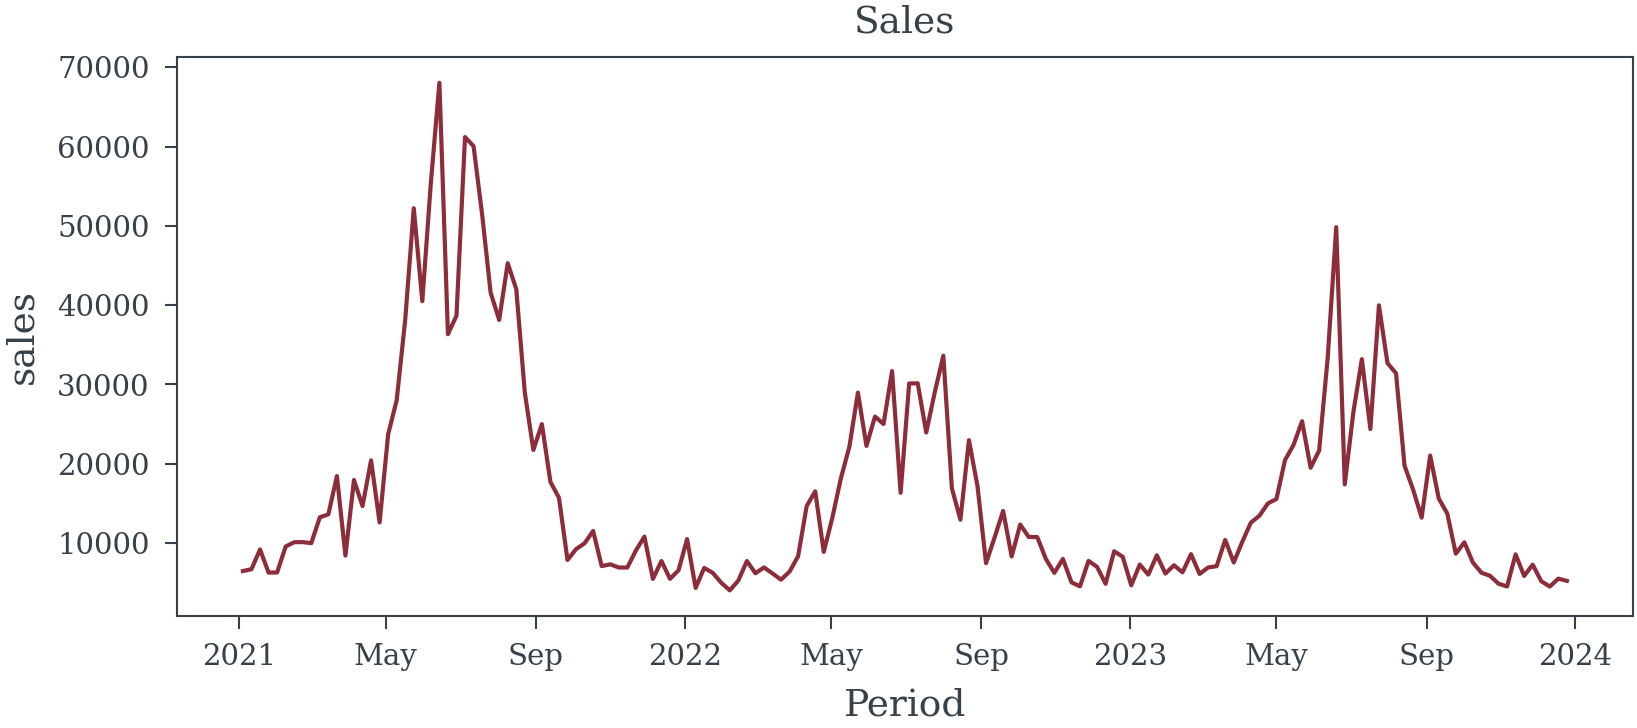

In [ ]:
#| echo: false
fig, ax = plt.subplots()
dataset.sales.plot(ax=ax)
ax.set_title("Sales");

## Paid Search Impressions

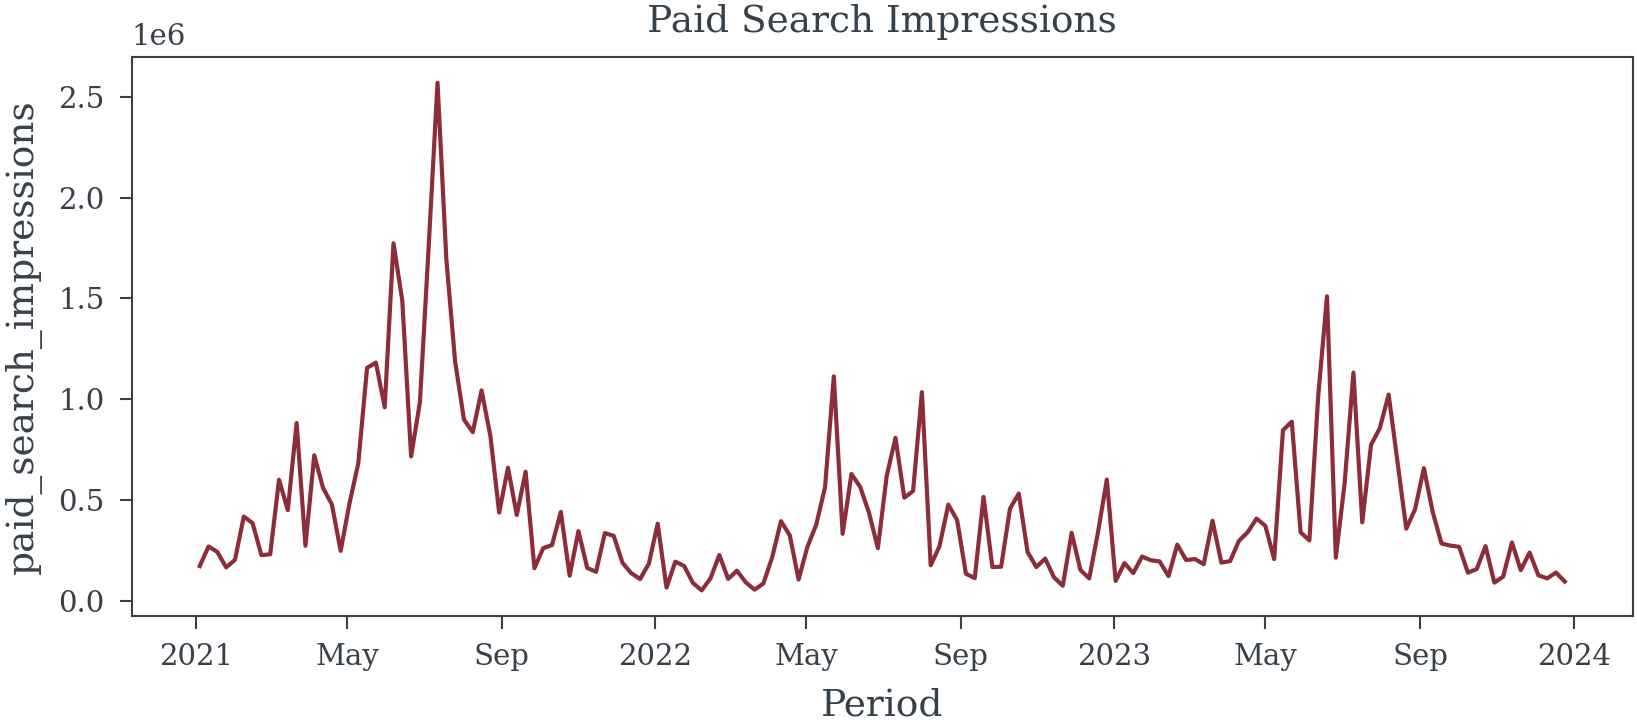

In [ ]:
#| echo: false
fig, ax = plt.subplots()
dataset.paid_search_impressions.plot(ax=ax)
ax.set_title("Paid Search Impressions");

## Search Query Volume

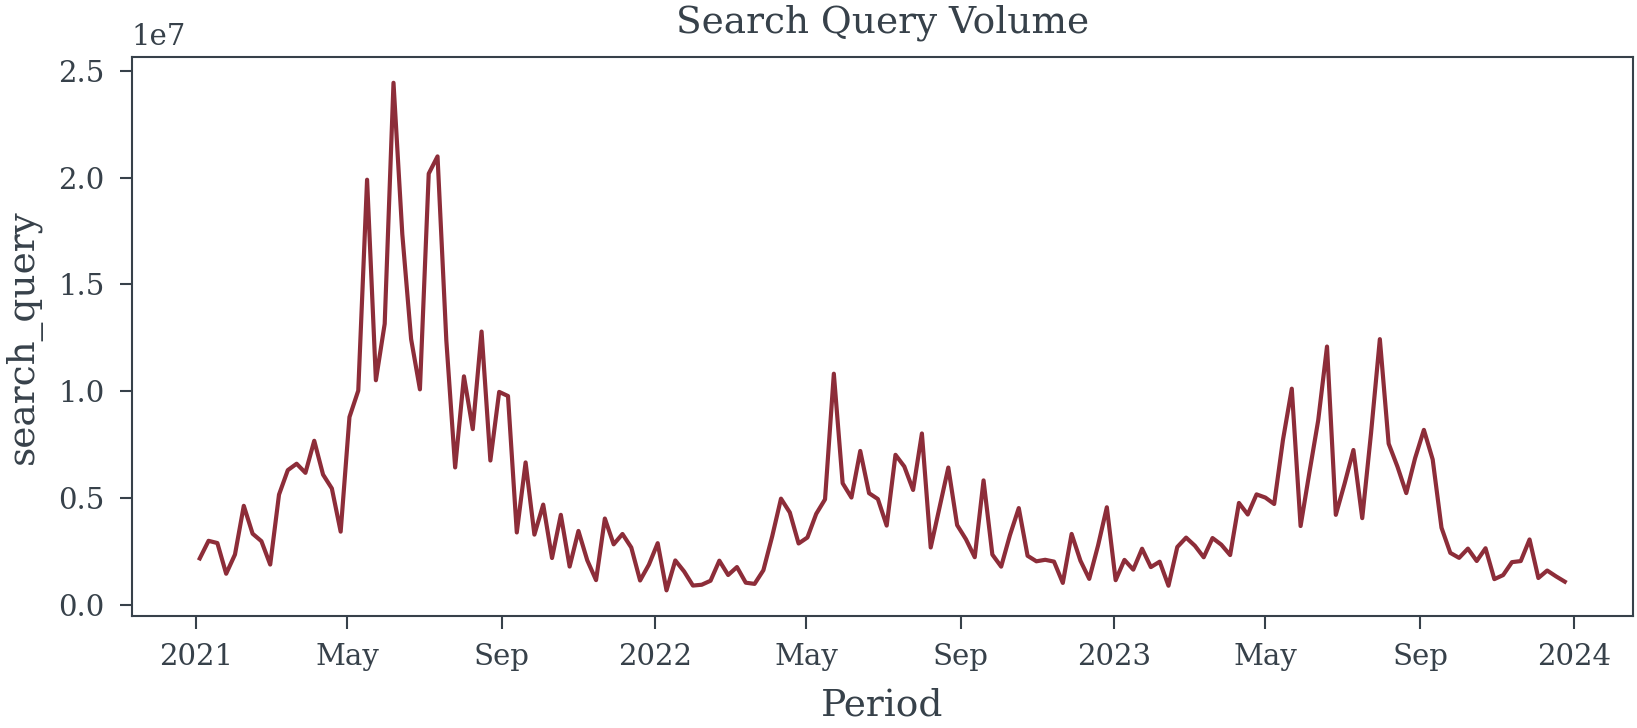

In [ ]:
#| echo: false
fig, ax = plt.subplots()
dataset.search_query.plot(ax=ax)
ax.set_title("Search Query Volume");

## Price

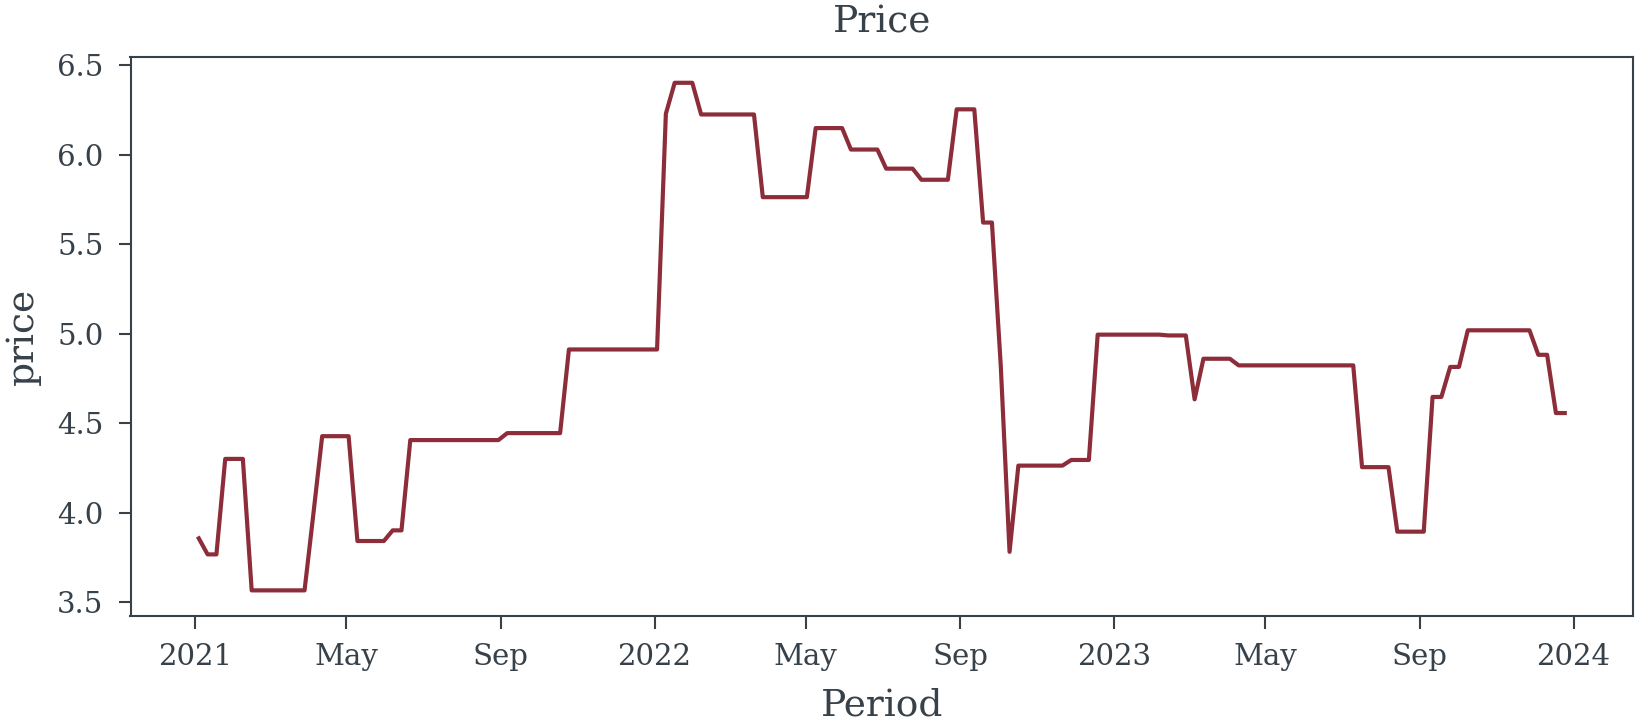

In [ ]:
#| echo: false
fig, ax = plt.subplots()
dataset.price.plot(ax=ax)
ax.set_title("Price");

:::

## Appendix B - OLV Data

::: {.panel-tabset}

## Sales

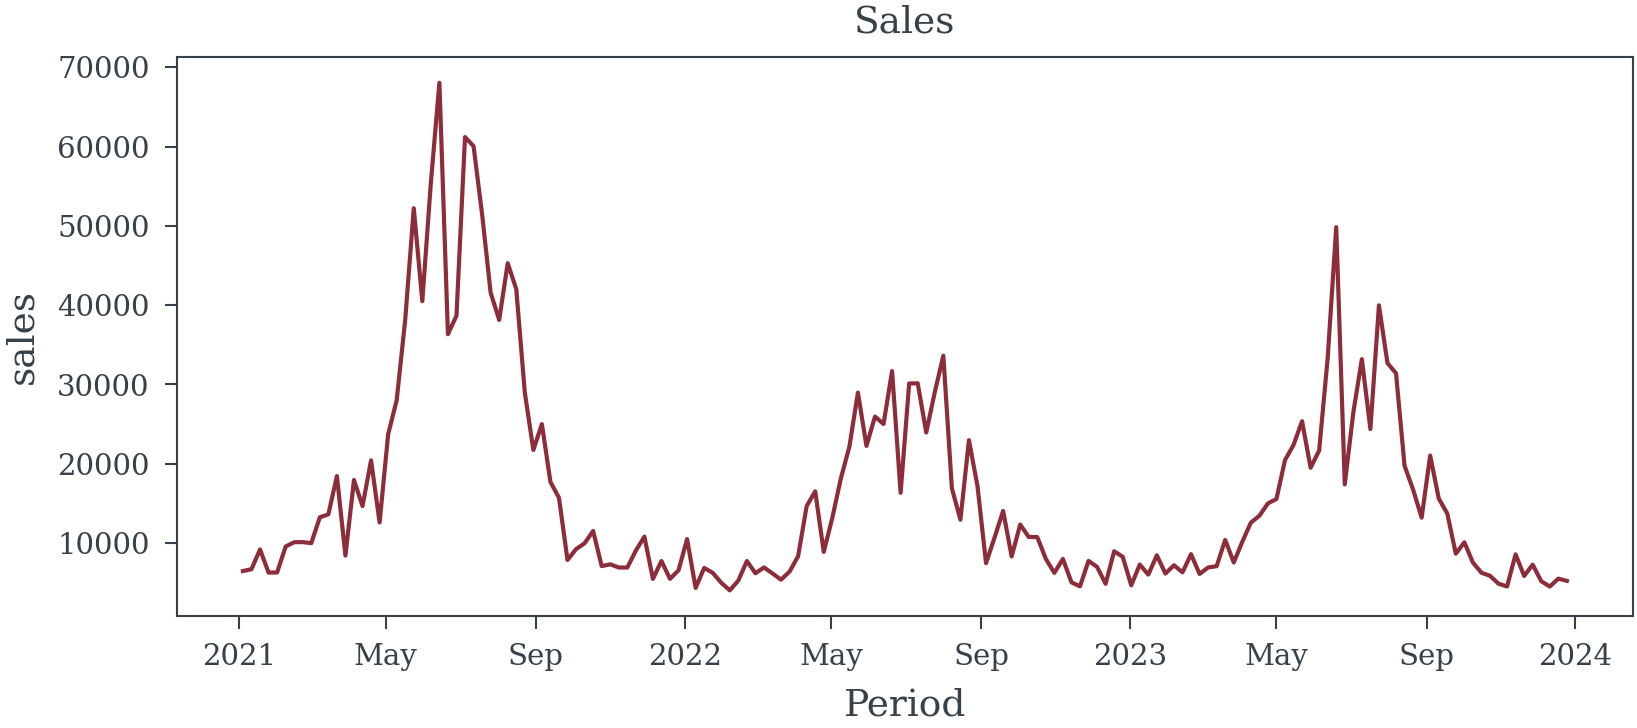

In [ ]:
#| echo: false
fig, ax = plt.subplots()
dataset.sales.plot(ax=ax)
ax.set_title("Sales");

## OLV Impressions

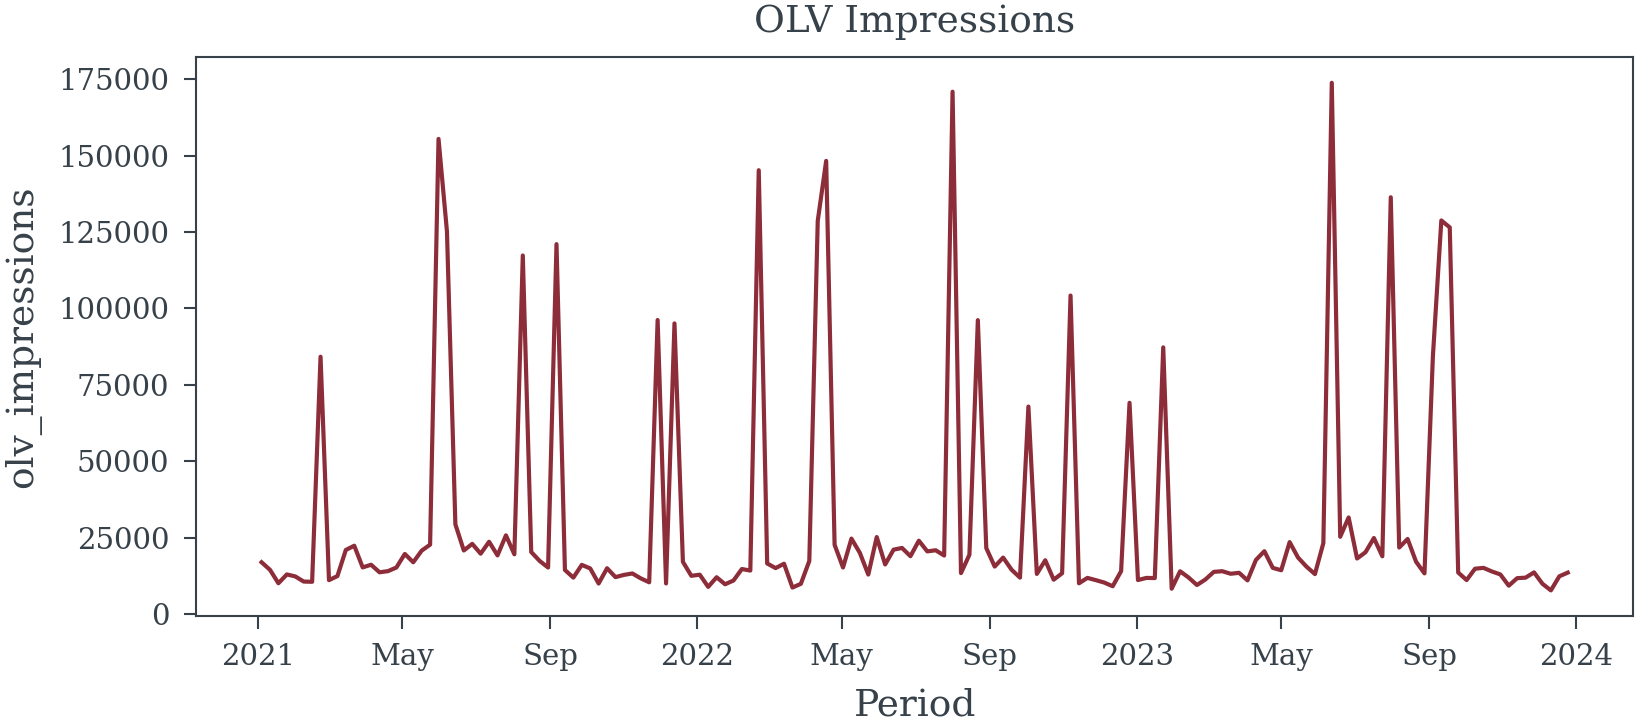

In [ ]:
#| echo: false
fig, ax = plt.subplots()
dataset.olv_impressions.plot(ax=ax)
ax.set_title("OLV Impressions");

## Video Platform Sentiment

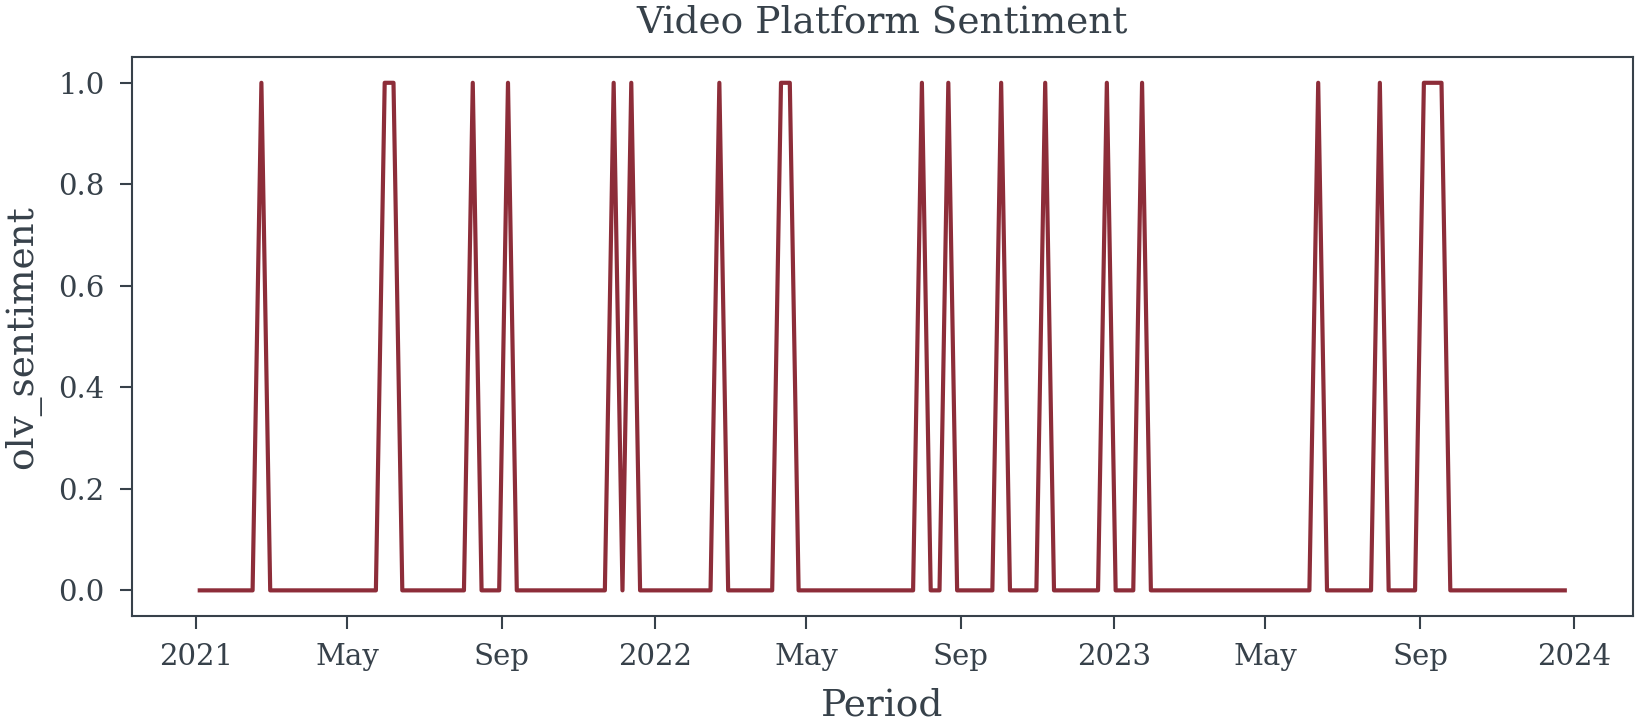

In [ ]:
#| echo: false
fig, ax = plt.subplots()
dataset.olv_sentiment.plot(ax=ax)
ax.set_title("Video Platform Sentiment");

## Price

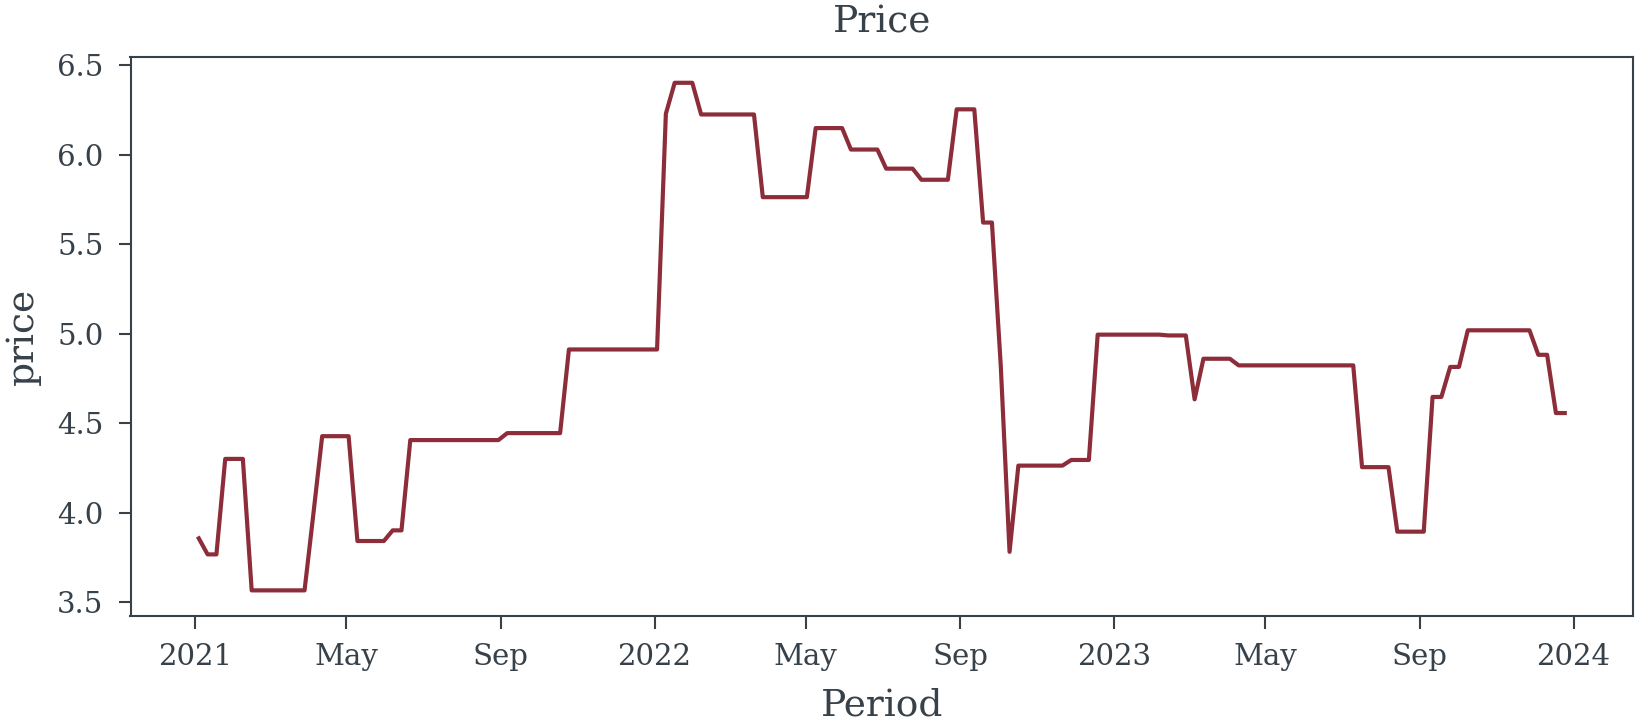

In [ ]:
#| echo: false
fig, ax = plt.subplots()
dataset.price.plot(ax=ax)
ax.set_title("Price");

:::

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()